# Classification with an Academic Success Dataset

The academic success dataset includes information related to students' academic paths, demographics and social-economic factors at the time of enrollment in university. The objective of this classification problem is to predict the enrollment status of each student at the end of the normal duration of their course, which can be one of the following:

- Dropout: the student has quit the course
- Enrolled: the student has not completed the course in the expected time
- Graduate: the student has completed the course

This notebook focuses on the application of supervised learning techniques and contains machine learning models capable of making accurate predictions regarding each student's graduation status.


## Exploratory Data Analysis

The following imports are used in this notebook:

- `pandas` and `numpy` for data manipulation and numerical operations.
- `seaborn` and `matplotlib.pyplot` for data visualization.
- `tqdm` for displaying progress bars during model evaluation.
- Scikit-learn modules for preprocessing, model selection, machine learning algorithms, and evaluation metrics.
- `%matplotlib inline` to display plots directly within the notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

We start by reading the CSV file and storing the data, setting the 'id' column as its index.

In [2]:
train = pd.read_csv("data/train.csv",index_col='id')

This is a large dataset, with 76518 rows and 37 columns. It was generated from a deep learning model trained on the original dataset

In [3]:
print("Dataset shape (rows, columns):", train.shape)

Dataset shape (rows, columns): (76518, 37)


In [ ]:
print("First 5 rows:")
train.head()

As we can see from the statistical summary, the numeric features of the dataset are not normalized. Most algorithms implemented in this notebook will require normalization.

In [ ]:
print("\nStatistical summary:")
train.describe()

There are no missing values, duplicated rows or incorrect target classes, hence we don't need to clean the data.

In [ ]:
print("\nMissing values in each column:")
train.isnull().sum()

In [ ]:
print("\nNumber of duplicate rows:")
print(train.duplicated().sum())

print("\nUnique classes:")
print(train['Target'].unique())

All features of the dataset, except the Target, are of a numeric type (int64 or float64). However, some of them correspond to categorical features which have already been encoded. Therefore, we will need to consult the original documentation to distinguish the categorical from the numeric features.

In [ ]:
print("\nDataset information:")
train.info()

There is not a significant imbalance between the distributions of the Target classes, though graduates make up nearly half of the students in the dataset.

In [ ]:
target_counts = train['Target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
sb.barplot(
    x=target_counts.index,
    y=target_counts.values,
    hue=target_counts.index,
    palette="viridis",
    dodge=False,
    legend=False,
    ax=axes[0]
)
axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Pie chart
axes[1].pie(
    target_counts.values,
    labels=target_counts.index,
    autopct='%1.1f%%'
)

fig.suptitle("Target Distribution", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The categorical features are stored in the cat_vars array. All other attributes are numeric, except for the Target.

In [5]:
cat_vars = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
            'Previous qualification', 'Nacionality', "Mother's qualification",
            "Father's qualification", "Mother's occupation", "Father's occupation",
            'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
            'Gender', 'Scholarship holder', 'International']

num_features = [col for col in train.columns if col not in cat_vars + ['Target']]

Now we will plot the distributions of the dataset's features. For categorical and integer numeric features, a bar count plot is used, while for float numeric features we'll use an histogram instead.

In [ ]:
features_to_plot = [col for col in train.columns if col not in ['Target']]

n_cols = 4
n_rows = int(np.ceil(len(features_to_plot) / n_cols))
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, idx)
    unique_count = train[col].nunique()
    hide_xticks = unique_count > 25

    if col in cat_vars:
        sb.countplot(data=train, x=col, hue=col, palette="viridis", legend=False)
        if hide_xticks:
            plt.xticks([])
        else:
            plt.xticks(rotation=45)
    else:
        if train[col].dtype == 'int64':
            sb.countplot(data=train, x=col, hue=col, palette="mako", legend=False)
            if hide_xticks:
                plt.xticks([])
            else:
                plt.xticks(rotation=45)
        elif train[col].dtype == 'float64':
            sb.histplot(train[col], kde=True, color="skyblue")
            if hide_xticks:
                plt.xticks([])
    plt.title(col)
    plt.tight_layout()

plt.show()

From the above figure we can see that several features, such as 'Marital status' and 'Nationality', are highly imbalanced.

The figure below includes the violin plots of the numeric features of the dataset.

In [ ]:
n_cols = 3
n_rows = int(np.ceil(len(num_features) / n_cols))
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for idx, feature in enumerate(num_features, 1):
    plt.subplot(n_rows, n_cols, idx)
    sb.violinplot(data=train, x='Target', y=feature, hue='Target', palette="Set2", legend=False)
    plt.title(feature)

plt.tight_layout()
plt.show()

An interesting observation from the violin plots is that there is not a significant difference in socio-economical features among the different target classes. On the other hand, features related to academic performance, such as grades, are strong differentiators, suggesting that these are more predictice of student outcomes in this dataset.

In [ ]:
plt.figure(figsize=(16, 12))
corr_matrix = train.iloc[:, :-1].corr()
sb.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix", fontsize=18)
plt.show()

- There are strong correlations among features related to academic performance.
- Socio-economical features, namely 'Unemployment rate', 'Inflation rate' and 'GDP', have very low correlation with all other features.

## Data Preprocessing

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])
print(train['Target'].unique())

# One-hot encoding for categorical variables
train = pd.get_dummies(train, columns=cat_vars, drop_first=True)

[2 0 1]


In [7]:
from sklearn.model_selection import train_test_split

X = train.drop('Target', axis=1)
y = train['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (61214, 274)
Test set shape: (15304, 274)


In [8]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print("Balanced class distribution:", np.bincount(y_train_bal))

Balanced class distribution: [29025 29025 29025]


In [9]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=20)
X_new = selector.fit_transform(X_train, y_train)

c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 45 106 154] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\diogo\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_s = X_train.copy()
X_test_s = X_test.copy()

X_train_s[num_features] = scaler.fit_transform(X_train[num_features])
X_test_s[num_features] = scaler.transform(X_test[num_features])

## Models

### k-Nearest Neighbors (k-NN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,31)]
scores = []

for k in tqdm(k_values, desc="Evaluating k values"):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_s, y_train, cv=5, n_jobs=-1)
    scores.append(np.mean(score))

sb.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_s, y_train)

y_pred = knn.predict(X_test_s)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)

### Decision Tree

Evaluating max_depths: 100%|██████████| 20/20 [02:47<00:00,  8.37s/it]


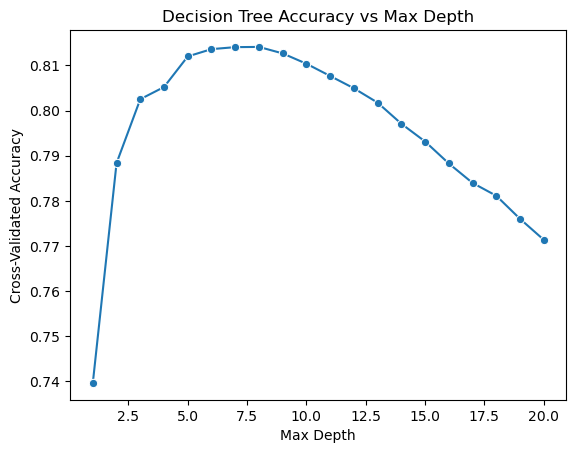

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

max_depths = range(1, 21)
dt_scores = []

for depth in tqdm(max_depths, desc="Evaluating max_depths"):
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    score = cross_val_score(dt, X_train, y_train, cv=5)
    dt_scores.append(np.mean(score))

sb.lineplot(x=max_depths, y=dt_scores, marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Decision Tree Accuracy vs Max Depth")
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

best_depth = int(np.argmax(dt_scores)) + 1
dt_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_best.fit(X_train, y_train)
y_pred_dt = dt_best.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("Best max_depth:", best_depth)
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)
print("Confusion Matrix:\n", cm_dt)

Best max_depth: 8
Accuracy: 0.8147543125980136
Precision: 0.816942945404814
Recall: 0.8147543125980136
F1 Score: 0.8137158261471032
Confusion Matrix:
 [[4025  658  376]
 [ 294 1784  910]
 [ 104  493 6660]]


### Multi-layer Perceptron (MLP) Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

mlp_hidden_sizes = [(50,), (100,), (150,), (100, 50), (100, 100)]
mlp_scores = []
for h in tqdm(mlp_hidden_sizes, desc="Evaluating hidden_layer_sizes"):
    mlp = MLPClassifier(hidden_layer_sizes=h, max_iter=100, random_state=42)
    score = cross_val_score(mlp, X_train_s, y_train, cv=3)
    mlp_scores.append(np.mean(score))

In [ ]:
results_df = pd.DataFrame({
    "Hidden Layer Sizes": [str(h) for h in mlp_hidden_sizes],
    "Accuracy": mlp_scores
})

plt.figure(figsize=(10, 6))
sb.barplot(data=results_df, x="Hidden Layer Sizes", y="Accuracy", hue="Hidden Layer Sizes", dodge=False, palette="viridis", legend=False)
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Cross-Validated Accuracy")
plt.title("MLP Accuracy vs Hidden Layer Sizes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42)
mlp.fit(X_train_s, y_train)
y_pred_mlp = mlp.predict(X_test_s)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

print("Accuracy:", accuracy_mlp)
print("Precision:", precision_mlp)
print("Recall:", recall_mlp)
print("F1 Score:", f1_mlp)
print("Confusion Matrix:\n", cm_mlp)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr_C_values = [0.01, 0.1, 0.5, 1, 2, 5]
lr_scores = []

for c in tqdm(lr_C_values, desc="Evaluating C values"):
    lr = LogisticRegression(C=c, max_iter=200, random_state=42)
    score = cross_val_score(lr, X_train_s, y_train, cv=3)
    lr_scores.append(np.mean(score))

sb.lineplot(x=lr_C_values, y=lr_scores, marker='o')
plt.xlabel("C Value")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Logistic Regression Accuracy vs C Value")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=200, random_state=42)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)
print("Confusion Matrix:\n", cm_lr)

## Emsemble (Voting Classifier)

In [ ]:
from sklearn.ensemble import VotingClassifier

# Instantiate models with best parameters
dt_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
mlp_best = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42)
knn_best = KNeighborsClassifier(n_neighbors=best_k)
lr_best = LogisticRegression(max_iter=200, random_state=42)

# SVM is omitted from the ensemble due to long training time and lack of predict_proba by default
ensemble = VotingClassifier(
    estimators=[
        ('dt', dt_best),
        ('mlp', mlp_best),
        ('knn', knn_best),
        ('lr', lr_best)
    ],
    voting='soft'
)

ensemble.fit(X_train_s, y_train)
y_pred_ensemble = ensemble.predict(X_test_s)

accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble, average='weighted')
recall_ensemble = recall_score(y_test, y_pred_ensemble, average='weighted')
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

print("Ensemble Accuracy:", accuracy_ensemble)
print("Ensemble Precision:", precision_ensemble)
print("Ensemble Recall:", recall_ensemble)
print("Ensemble F1 Score:", f1_ensemble)
print("Ensemble Confusion Matrix:\n", cm_ensemble)

## Overall Analysis and Comparison of Algorithms

In [ ]:
summary_df = pd.DataFrame({
    'Algorithm': [
        'Decision Tree',
        'MLP',
        'k-NN',
        'Logistic Regression'
    ],
    'Accuracy': [
        accuracy_dt,
        accuracy_mlp,
        accuracy,  # k-NN
        accuracy_lr
    ],
    'Precision': [
        precision_dt,
        precision_mlp,
        precision,  # k-NN
        precision_lr
    ],
    'Recall': [
        recall_dt,
        recall_mlp,
        recall,  # k-NN
        recall_lr
    ],
    'F1 Score': [
        f1_dt,
        f1_mlp,
        f1,  # k-NN
        f1_lr
    ]
})
summary_df

In [ ]:
# Plot comparison of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(12, 7))
summary_melted = summary_df.melt(id_vars='Algorithm', value_vars=metrics, var_name='Metric', value_name='Score')
sb.barplot(data=summary_melted, x='Metric', y='Score', hue='Algorithm', palette='viridis')
plt.title('Comparison of Classification Algorithms')
plt.ylim(0, 1)
plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize confusion matrices for all algorithms
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
algorithms = ['Decision Tree', 'MLP', 'k-NN', 'Logistic Regression']
cms = [cm_dt, cm_mlp, cm, cm_lr]
for ax, name, cmatrix in zip(axes, algorithms, cms):
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)
plt.suptitle('Confusion Matrices of All Algorithms', fontsize=16)
plt.tight_layout()
plt.show()